In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd

from glob import glob

import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions     as fitf
from   invisible_cities.core.stat_functions    import poisson_sigma
from   invisible_cities.core.core_functions import shift_to_bin_centers

import invisible_cities.reco.dst_functions     as dstf

from   invisible_cities.icaro.hst_functions    import hist
from   invisible_cities.icaro.hst_functions    import gausstext

In [2]:
import next_analysis.utils.histo_functions    as myhf
import next_analysis.utils.topology_functions as topo

In [3]:
### Useful parameters for plots
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 10, 7.5
plt.rcParams['figure.max_open_warning']= 0

fucsia = myhf.tableau20[6]
blue = myhf.tableau20[0]

### Peak

In [4]:
xe_peak = 2458
pe2keV = 1405649.5 / xe_peak

### Load files

In [5]:
def load_files(r):
    xe_file = '/home/jmbenlloch/next/next100/xe0nu/paolina_optimization/voxel15.0mm_sipm30pes_r{}.0mm/dst/filtered_tracking_drop_voxels_1hit_perSiPM_30pes_xe0nu_run4_check_vxl15.h5'.format(r)
    tl_file = '/home/jmbenlloch/next/next100/Tl/paolina_optimization/voxel15.0mm_sipm30pes_r{}.0mm/dst/filtered_tracking_drop_voxels_1hit_perSiPM_30pes_tl208_run4_check_vxl15.h5'.format(r)
    bi_file = '/home/jmbenlloch/next/next100/Bi/paolina_optimization/voxel15.0mm_sipm30pes_r{}.0mm/dst/filtered_tracking_drop_voxels_1hit_perSiPM_30pes_bi214_run4_check_vxl15.h5'.format(r)
    
    df_xe = pd.read_hdf(xe_file, 'tracks')
    df_tl = pd.read_hdf(tl_file, 'tracks')
    df_bi = pd.read_hdf(bi_file, 'tracks')
    
    return df_xe, df_tl, df_bi

### Plot spectrum

In [6]:
def get_energies(df):
    energies = df[['event', 'evt_energy_cal']]
    energies = energies.drop_duplicates('event')
    energy   = energies.evt_energy_cal
    
    return energy

In [7]:
def plot_spectrum(energies, bins=100, range=None, title='', fit=False, fit_range=None, seed=None, peak=0):
    #plt.rcParams["font.size"] = 20
    fig = plt.figure()
    fig.set_figwidth(10.0)
    fig.set_figheight(7.0)
    
    y, x, _ = hist(energies, bins=bins, range=range ,new_figure=False)

    plt.xlabel('Energy (pes)')
    plt.ylabel('Counts/bin')
    plt.title(title)
    
    if fit:
        sigma = poisson_sigma(y)
        f_one    = fitf.fit(myhf.gauss, x, y, seed, fit_range=fit_range, sigma=sigma)
        print('Chi2 = {}'.format(f_one.chi2))
        legend = gausstext(f_one.values[:], f_one.errors[:], peak, 2458)
        xmin = min(x)
        xmax = max(x)
        mx = np.linspace(xmin, xmax, 1000)
        plt.plot(mx, f_one.fn(mx), 'r-', label=legend)
        plt.plot(mx, f_one.fn(mx), 'r-')
        plt.legend(loc=0)

        resolution = f_one.values[2] / f_one.values[1] * 2.35 * 100
        print(f_one.values)
        
        return f_one

In [8]:
def plot_spectrums(energies_xe, energies_tl, energies_bi, bins=100, range=None):
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    ax1.hist(energies_xe, bins=bins, range=range)
    ax1.set_xlabel('Energy (pes)')
    ax1.set_ylabel('Counts/bin')
    ax1.set_title('Xe0nu')
    
    ax2.hist(energies_tl, bins=bins, range=range)
    ax2.set_xlabel('Energy (pes)')
    ax2.set_ylabel('Counts/bin')
    ax2.set_title('Tl')
    
    ax3.hist(energies_tl, bins=bins, range=range)
    ax3.set_xlabel('Energy (pes)')
    ax3.set_ylabel('Counts/bin')
    ax3.set_title('Bi')

### Apply ROI

In [10]:
#ROI Javi
roi_e_min = 2448
roi_e_max = 2477

In [11]:
def apply_energy_roi(df, e_min, e_max, pe2keV):
    df_roi = df[(df.energy/pe2keV > e_min) & (df.energy/pe2keV < e_max)]
    nevts  = df_roi.event.unique().shape[0]
    print("Events in ROI:\t{}".format(nevts))
    return df_roi, nevts

### Topology 

In [12]:
start =   0
end   = 490
step  =  15

In [13]:
def topology_scan(df_xe, df_tl, df_bi, start, end, step, pe2keV):
    thresholds = []

    xe_evts = []
    tl_evts = []
    bi_evts = []

    for threshold in range(start, end, step):
        xe_cut = df_xe[(df_xe.eblob2.values / pe2keV) > threshold]
        tl_cut = df_tl[(df_tl.eblob2.values / pe2keV) > threshold]
        bi_cut = df_bi[(df_bi.eblob2.values / pe2keV) > threshold]

        energies_tl = get_energies(tl_cut)
        energies_xe = get_energies(xe_cut)
        energies_bi = get_energies(bi_cut)

        thresholds.append(threshold)
        tl_evts   .append(energies_tl.shape[0])
        bi_evts   .append(energies_bi.shape[0])
        xe_evts   .append(energies_xe.shape[0])

    xe_evts = np.array(xe_evts)
    bi_evts = np.array(bi_evts)
    tl_evts = np.array(tl_evts)    
    
    return thresholds, xe_evts, tl_evts, bi_evts

### Efficiencies

In [14]:
def compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts):
    xe_evts_norm = xe_evts / xe_evts[0]
    bi_evts_norm = bi_evts / bi_evts[0]
    tl_evts_norm = tl_evts / tl_evts[0]
    
    errors_xe = np.sqrt(xe_evts_norm * (1 - xe_evts_norm) / xe_evts[0])
    errors_tl = np.sqrt(tl_evts_norm * (1 - tl_evts_norm) / tl_evts[0])
    errors_bi = np.sqrt(bi_evts_norm * (1 - bi_evts_norm) / bi_evts[0])
    
    return xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi

In [15]:
def plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi):
    fig = plt.figure(1);
    fig.set_figwidth(10.);
    fig.set_figheight(8.);

    plt.rcParams["font.size"] = 20

    plt.errorbar(thresholds, xe_evts_norm, xerr=step/2, yerr=errors_xe, fmt='s', ecolor='black', marker='s', capsize=3, label='Xe', color='green')
    plt.errorbar(thresholds, tl_evts_norm, xerr=step/2, yerr=errors_tl, fmt='s', ecolor='black', marker='s', capsize=3, label='Tl', color='blue')
    plt.errorbar(thresholds, bi_evts_norm, xerr=step/2, yerr=errors_bi, fmt='s', ecolor='black', marker='s', capsize=3, label='Bi', color='red')

    #plt.yticks(np.arange(0, 1.1, step=0.05))
    #plt.grid()

    plt.xlabel('Blob 2 energy cut (keV)')
    plt.ylabel('Efficiency')
    lnd = plt.legend(loc=3)

### ROC curve

In [16]:
def compute_figure_of_merit(sig_eff, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi):
    fom_tl = sig_eff/np.sqrt(tl_evts_norm)
    fom_bi = sig_eff/np.sqrt(bi_evts_norm)
    
    fom_tl_err = np.sqrt(errors_xe**2/tl_evts_norm + errors_tl**2*sig_eff**2/(4*tl_evts_norm**3))
    fom_bi_err = np.sqrt(errors_xe**2/bi_evts_norm + errors_bi**2*sig_eff**2/(4*bi_evts_norm**3))
    
    return fom_tl, fom_bi, fom_tl_err, fom_bi_err

In [17]:
def plot_roc_curve(sig_eff, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step):
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.rcParams["font.size"] = 20

    ax1.errorbar(bkg_rej_tl, sig_eff, xerr=errors_tl, yerr=errors_xe, fmt='s', ecolor='black', marker='s', capsize=3, label='Xe0nu/Tl')
    ax1.errorbar(bkg_rej_bi, sig_eff, xerr=errors_bi, yerr=errors_xe, fmt='s', ecolor='black', marker='s', capsize=3, label='Xe0nu/Bi', color='red')

    ax1.set_xlabel('Background rejection')
    ax1.set_ylabel('Signal efficiency')
    ax1.legend(loc=3)
    
    ms = 7
    lw = 2
    x = range(start, end, step)
    err_x = np.full((1, len(x)), step/2.)

    ax2.errorbar(x, fom_tl, xerr=step/2, yerr=fom_tl_err, fmt='s', markersize=ms, linewidth=lw, capsize=3, label='Xe0nu/Tl', ecolor='black')
    ax2.errorbar(x, fom_bi, xerr=step/2, yerr=fom_bi_err, fmt='s', markersize=ms, linewidth=lw, capsize=3, label='Xe0nu/Bi', ecolor='black', color='red')
    ax2.set_xlabel('Blob 2 energy threshold (keV)')
    ax2.set_ylabel(r'f.o.m. ($\varepsilon_{\rm s}/\sqrt{\varepsilon_{\rm b}}$)')
    ax2.legend(loc=2)

### Blobs energy

In [18]:
def get_blob_energies(df_xe, df_tl, df_bi):
    eblob1_peak_xe = df_xe.eblob1.values/pe2keV
    eblob2_peak_xe = df_xe.eblob2.values/pe2keV

    eblob1_peak_tl = df_tl.eblob1.values/pe2keV
    eblob2_peak_tl = df_tl.eblob2.values/pe2keV

    eblob1_peak_bi = df_bi.eblob1.values/pe2keV
    eblob2_peak_bi = df_bi.eblob2.values/pe2keV
    
    return eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi

In [21]:
# Plot Eblob1 vs. Eblob2
def plot_blobs_energy(xe_blob1, xe_blob2, tl_blob1, tl_blob2, bi_blob1, bi_blob2,):
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    plt.rcParams.update({'font.size': 16})
    bins_blobs = 25
    range_blobs = 1200
    
    ax1.hist2d(xe_blob1, xe_blob2, bins=bins_blobs, range=((0, range_blobs), (0, range_blobs)), cmin=1);
    ax1.set_xlabel("Higher blob candidate energy (keV)")
    ax1.set_ylabel("Lower blob candidate energy (keV)")
    ax1.set_title("Xe0nu")
    
    ax2.hist2d(tl_blob1, tl_blob2, bins=bins_blobs, range=((0, range_blobs), (0, range_blobs)), cmin=1);
    ax2.set_xlabel("Higher blob candidate energy (keV)")
    ax2.set_ylabel("Lower blob candidate energy (keV)")
    ax2.set_title("Tl")
    
    ax3.hist2d(bi_blob1, bi_blob2, bins=bins_blobs, range=((0, range_blobs), (0, range_blobs)), cmin=1);
    ax3.set_xlabel("Higher blob candidate energy (keV)")
    ax3.set_ylabel("Lower blob candidate energy (keV)")
    ax3.set_title("Bi")

# Paolina with $r=12$

In [22]:
df_xe, df_tl, df_bi = load_files(r = 12)

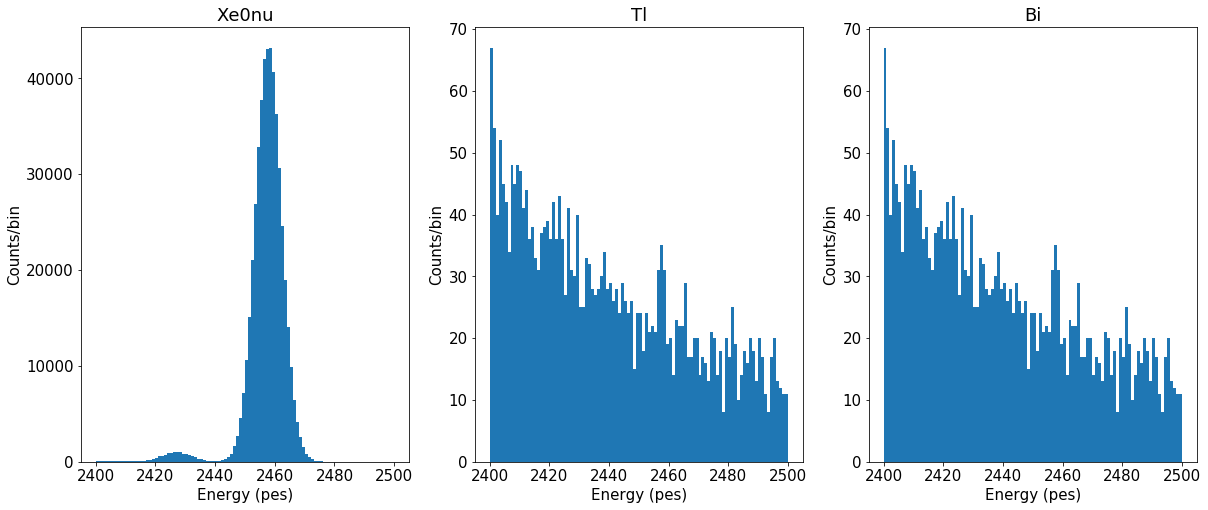

In [23]:
energies_xe = get_energies(df_xe)
energies_tl = get_energies(df_tl)
energies_bi = get_energies(df_bi)

plot_spectrums(energies_xe, energies_tl, energies_bi, range=(2400, 2500))

Chi2 = 5.302821196883853
[4.81405811e+05 2.45786015e+03 4.42711608e+00]


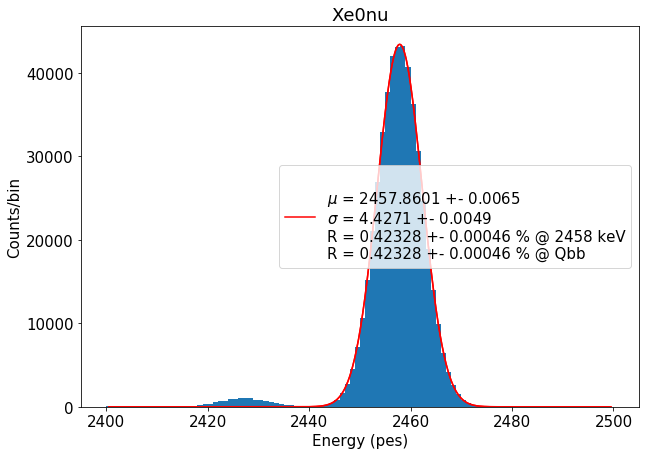

In [24]:
fit_result = plot_spectrum(energies_xe, range=(2400, 2500), title="Xe0nu", fit=True, seed=(100, 2458, 23), fit_range=(2440, 2470), peak=xe_peak)

Events in ROI:	475701
Events in ROI:	604
Events in ROI:	258


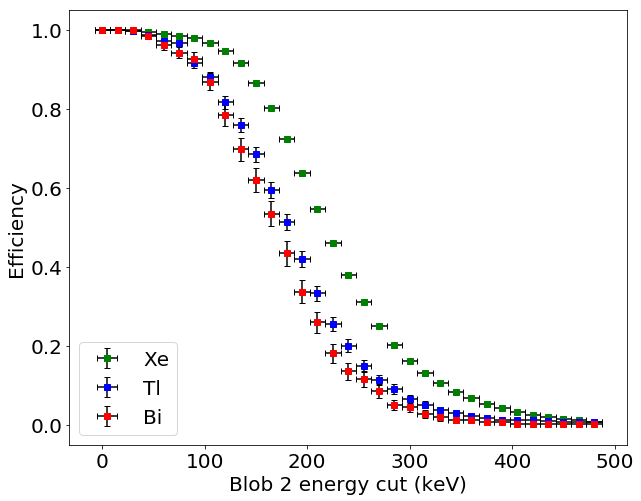

In [25]:
df_xe_roi, _ = apply_energy_roi(df_xe, roi_e_min, roi_e_max, pe2keV)
df_tl_roi, _ = apply_energy_roi(df_tl, roi_e_min, roi_e_max, pe2keV)
df_bi_roi, _ = apply_energy_roi(df_bi, roi_e_min, roi_e_max, pe2keV)

thresholds, xe_evts, tl_evts, bi_evts = topology_scan(df_xe_roi, df_tl_roi, df_bi_roi, start, end, step, pe2keV)
xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi = compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts)
plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

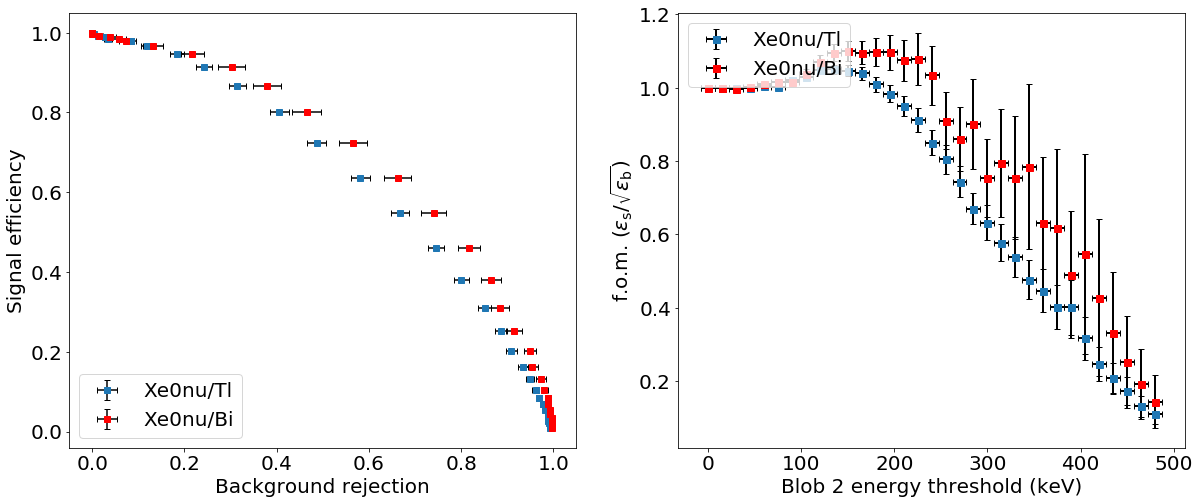

In [26]:
fom_tl, fom_bi, fom_tl_err, fom_bi_err = compute_figure_of_merit(xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

bkg_rej_tl = 1 - tl_evts_norm
bkg_rej_bi = 1 - bi_evts_norm
plot_roc_curve(xe_evts_norm, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step)

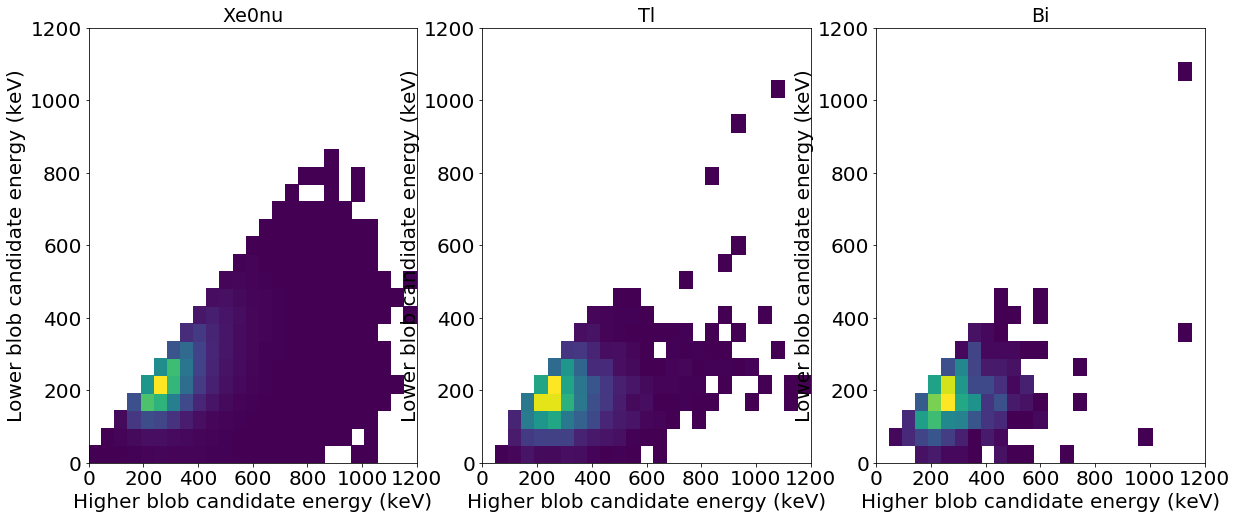

In [27]:
eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi = get_blob_energies(df_xe, df_tl, df_bi)
plot_blobs_energy(eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi)

# Paolina with $r=15$

In [28]:
df_xe, df_tl, df_bi = load_files(r = 15)

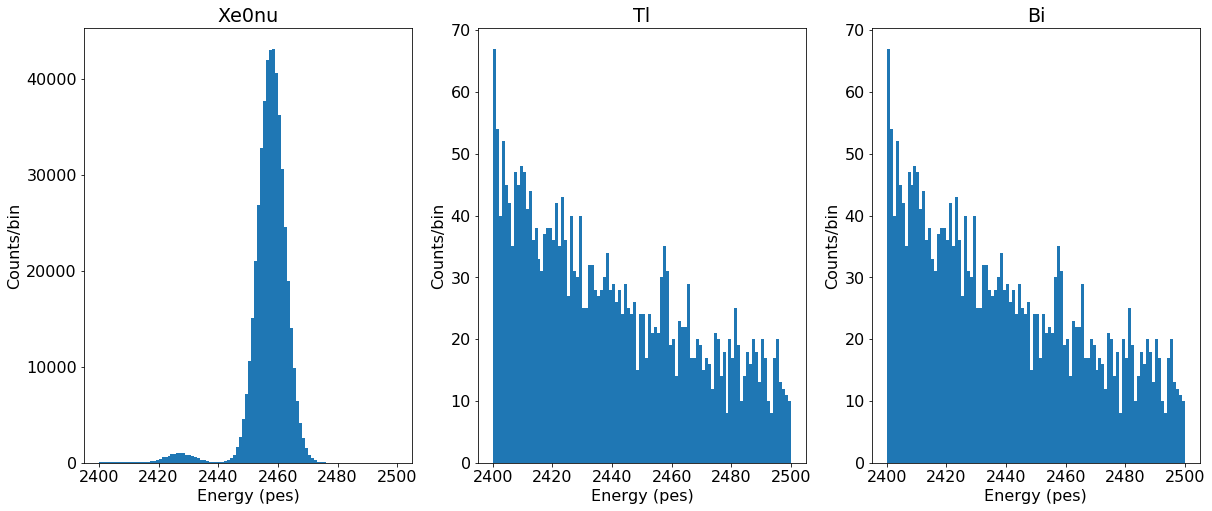

In [29]:
energies_xe = get_energies(df_xe)
energies_tl = get_energies(df_tl)
energies_bi = get_energies(df_bi)

plot_spectrums(energies_xe, energies_tl, energies_bi, range=(2400, 2500))

Events in ROI:	475433
Events in ROI:	601
Events in ROI:	259


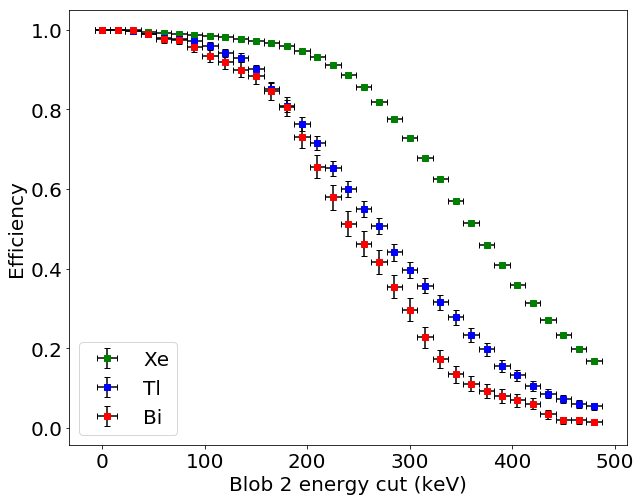

In [30]:
df_xe_roi, _ = apply_energy_roi(df_xe, roi_e_min, roi_e_max, pe2keV)
df_tl_roi, _ = apply_energy_roi(df_tl, roi_e_min, roi_e_max, pe2keV)
df_bi_roi, _ = apply_energy_roi(df_bi, roi_e_min, roi_e_max, pe2keV)

thresholds, xe_evts, tl_evts, bi_evts = topology_scan(df_xe_roi, df_tl_roi, df_bi_roi, start, end, step, pe2keV)
xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi = compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts)
plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

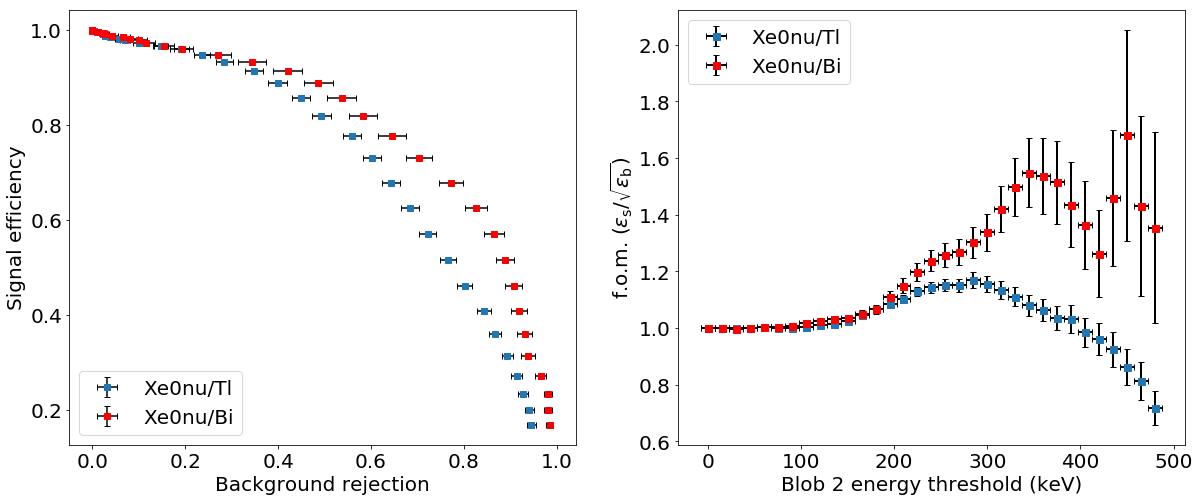

In [31]:
fom_tl, fom_bi, fom_tl_err, fom_bi_err = compute_figure_of_merit(xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

bkg_rej_tl = 1 - tl_evts_norm
bkg_rej_bi = 1 - bi_evts_norm
plot_roc_curve(xe_evts_norm, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step)

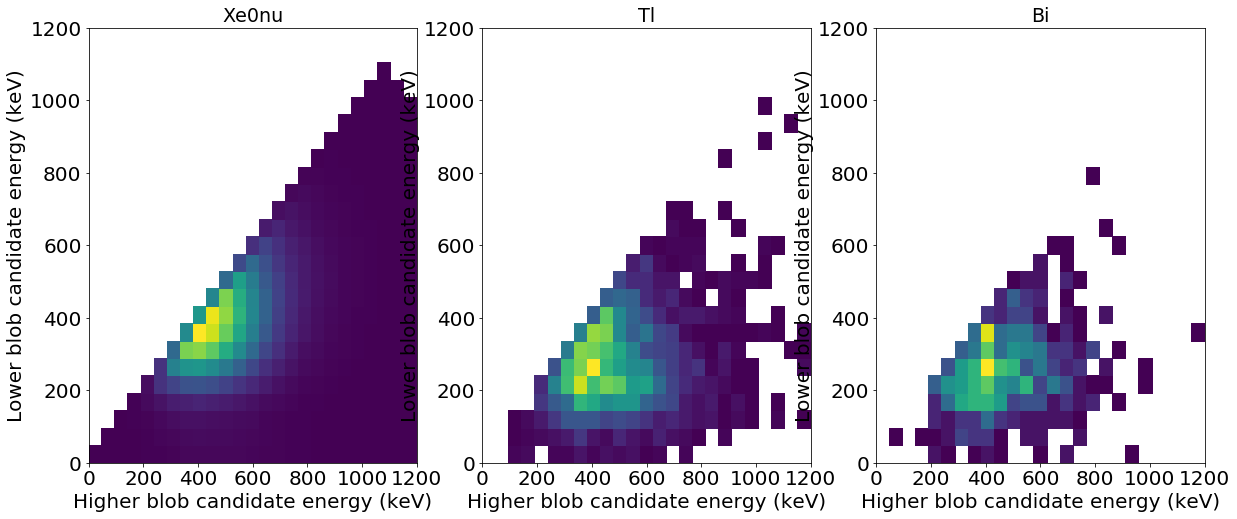

In [32]:
eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi = get_blob_energies(df_xe, df_tl, df_bi)
plot_blobs_energy(eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi)

# Paolina with $r=18$

In [33]:
df_xe, df_tl, df_bi = load_files(r = 18)

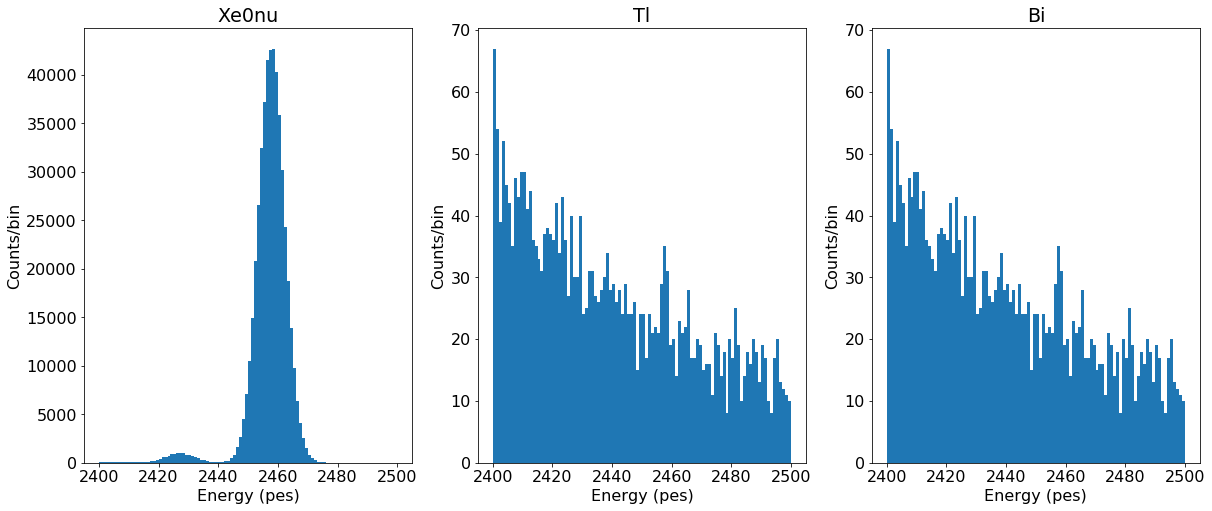

In [34]:
energies_xe = get_energies(df_xe)
energies_tl = get_energies(df_tl)
energies_bi = get_energies(df_bi)

plot_spectrums(energies_xe, energies_tl, energies_bi, range=(2400, 2500))

Events in ROI:	470102
Events in ROI:	595
Events in ROI:	259


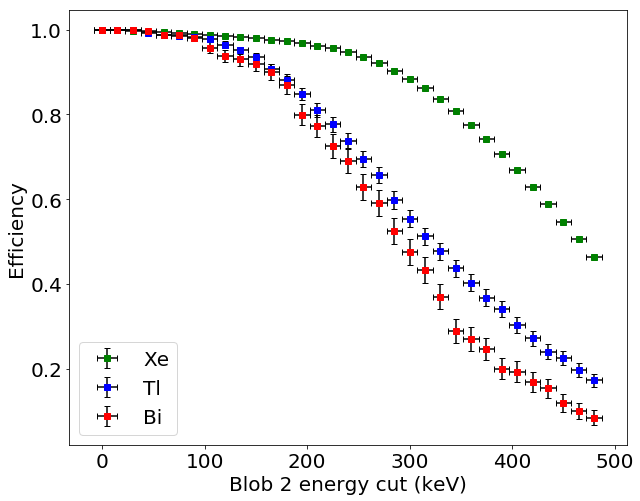

In [35]:
df_xe_roi, _ = apply_energy_roi(df_xe, roi_e_min, roi_e_max, pe2keV)
df_tl_roi, _ = apply_energy_roi(df_tl, roi_e_min, roi_e_max, pe2keV)
df_bi_roi, _ = apply_energy_roi(df_bi, roi_e_min, roi_e_max, pe2keV)

thresholds, xe_evts, tl_evts, bi_evts = topology_scan(df_xe_roi, df_tl_roi, df_bi_roi, start, end, step, pe2keV)
xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi = compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts)
plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

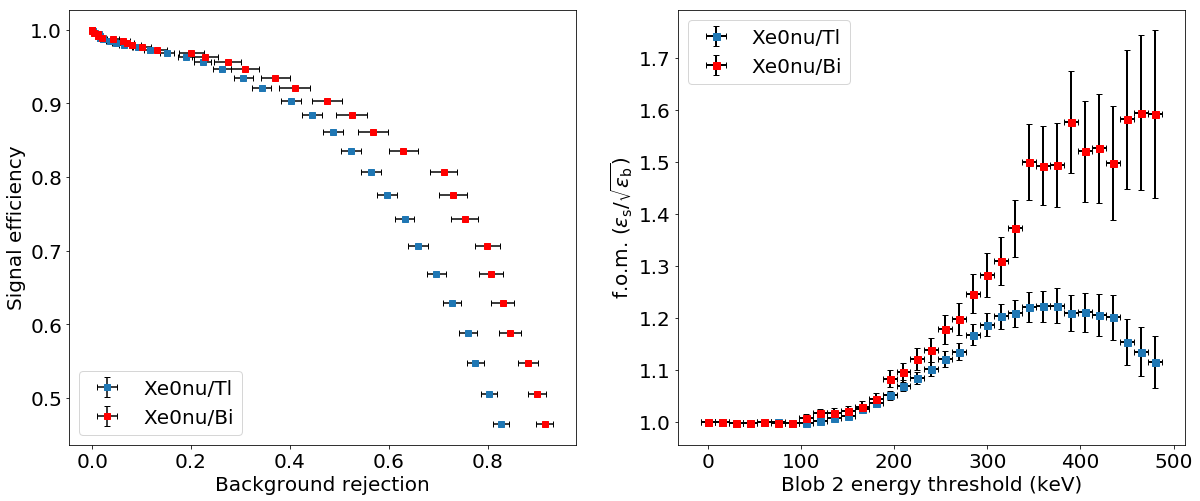

In [36]:
fom_tl, fom_bi, fom_tl_err, fom_bi_err = compute_figure_of_merit(xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

bkg_rej_tl = 1 - tl_evts_norm
bkg_rej_bi = 1 - bi_evts_norm
plot_roc_curve(xe_evts_norm, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step)

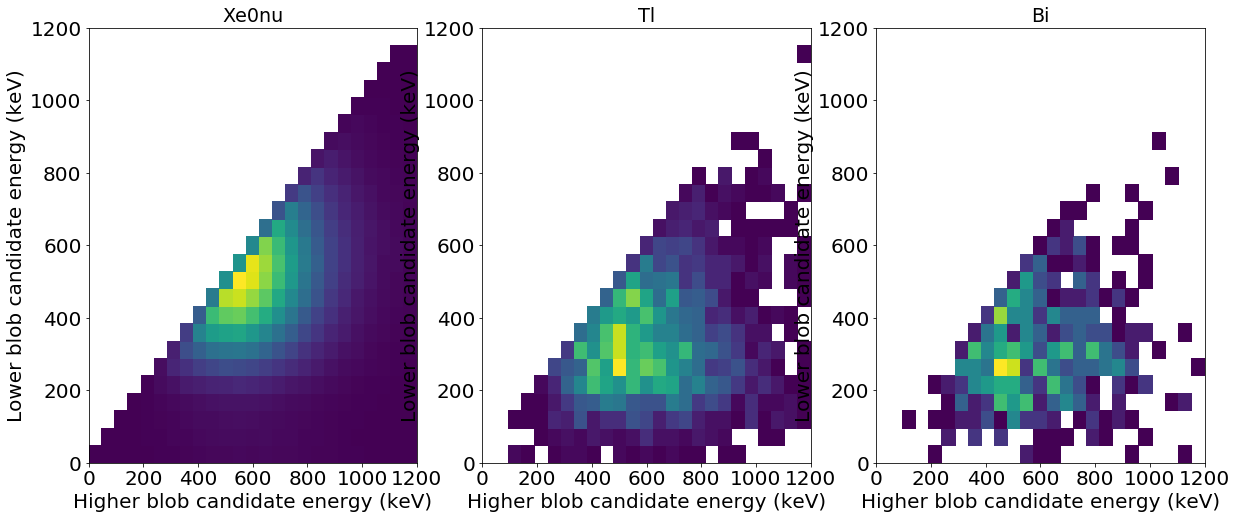

In [37]:
eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi = get_blob_energies(df_xe, df_tl, df_bi)
plot_blobs_energy(eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi)

# Paolina with $r=21$

In [38]:
df_xe, df_tl, df_bi = load_files(r = 21)

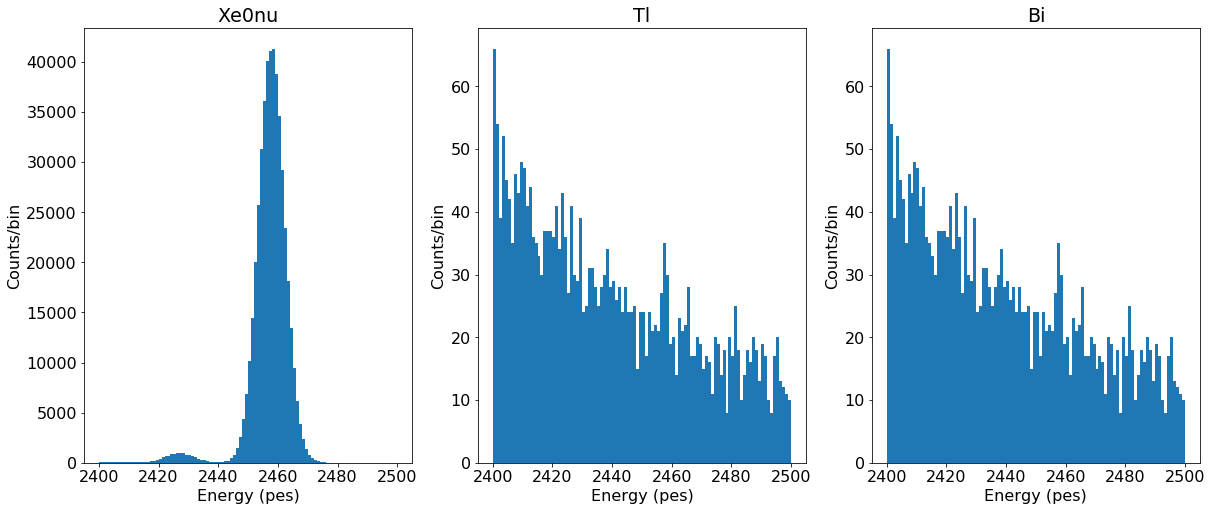

In [39]:
energies_xe = get_energies(df_xe)
energies_tl = get_energies(df_tl)
energies_bi = get_energies(df_bi)

plot_spectrums(energies_xe, energies_tl, energies_bi, range=(2400, 2500))

Events in ROI:	454189
Events in ROI:	592
Events in ROI:	259


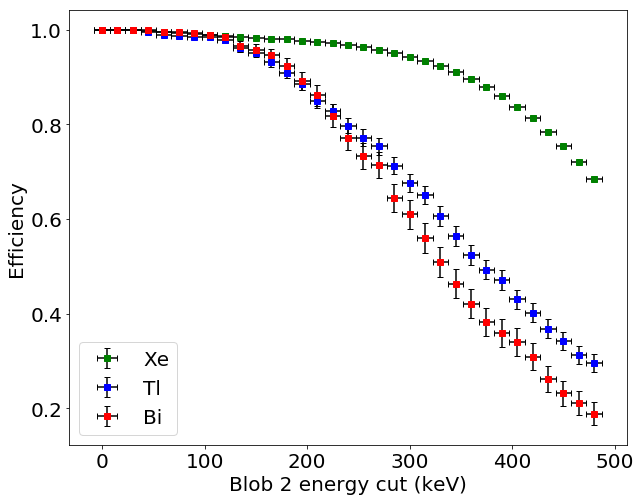

In [40]:
df_xe_roi, _ = apply_energy_roi(df_xe, roi_e_min, roi_e_max, pe2keV)
df_tl_roi, _ = apply_energy_roi(df_tl, roi_e_min, roi_e_max, pe2keV)
df_bi_roi, _ = apply_energy_roi(df_bi, roi_e_min, roi_e_max, pe2keV)

thresholds, xe_evts, tl_evts, bi_evts = topology_scan(df_xe_roi, df_tl_roi, df_bi_roi, start, end, step, pe2keV)
xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi = compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts)
plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

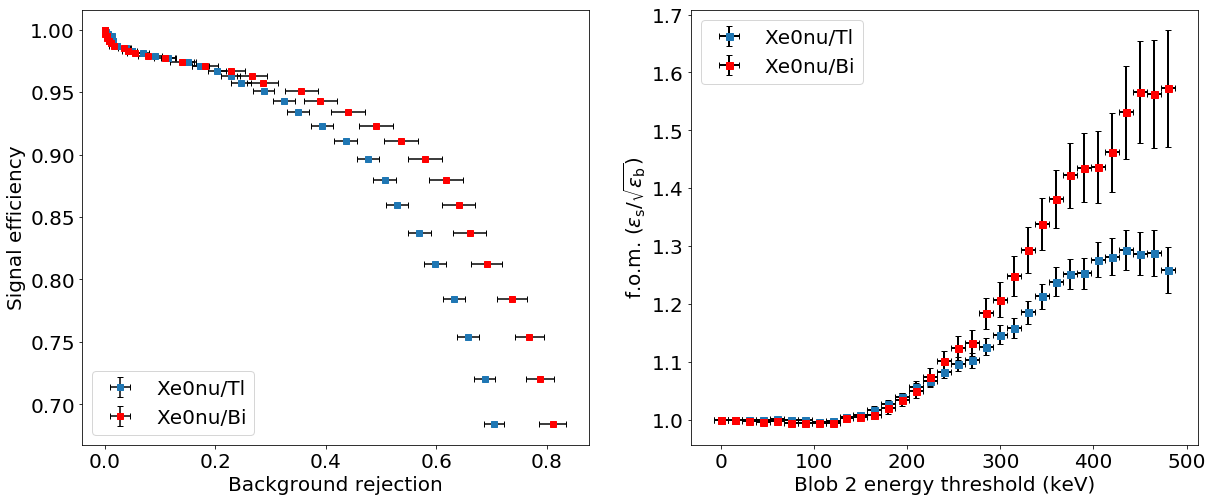

In [41]:
fom_tl, fom_bi, fom_tl_err, fom_bi_err = compute_figure_of_merit(xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

bkg_rej_tl = 1 - tl_evts_norm
bkg_rej_bi = 1 - bi_evts_norm
plot_roc_curve(xe_evts_norm, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step)

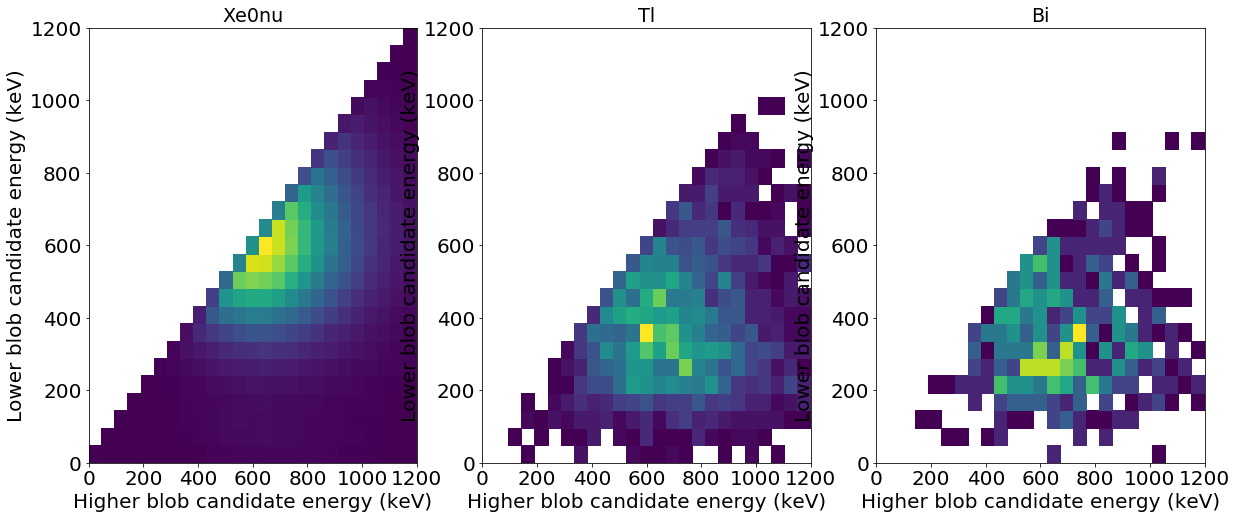

In [42]:
eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi = get_blob_energies(df_xe, df_tl, df_bi)
plot_blobs_energy(eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi)

# Paolina with $r=24$

In [43]:
df_xe, df_tl, df_bi = load_files(r = 24)

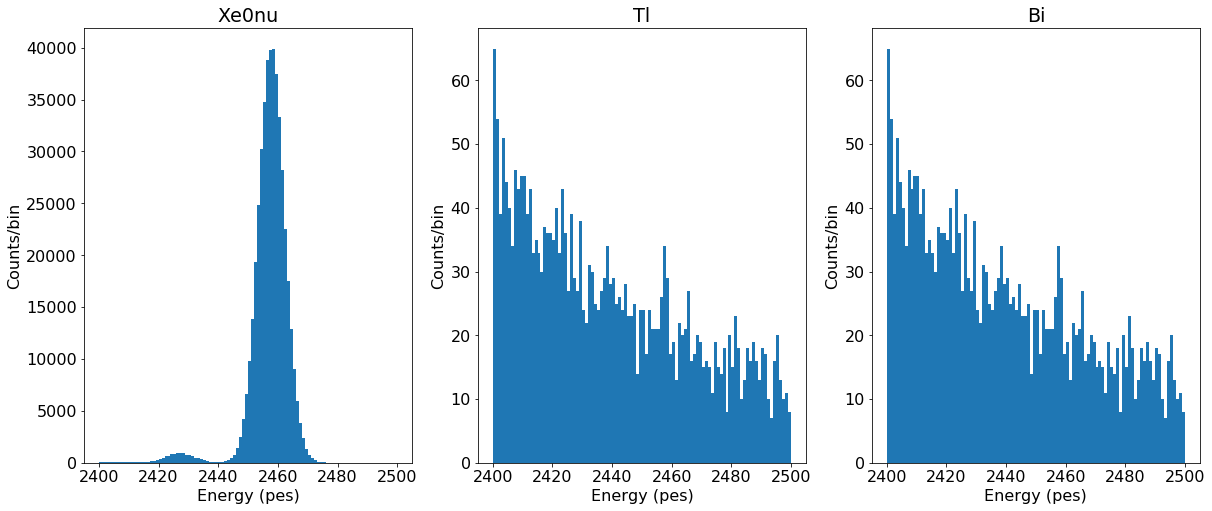

In [44]:
energies_xe = get_energies(df_xe)
energies_tl = get_energies(df_tl)
energies_bi = get_energies(df_bi)

plot_spectrums(energies_xe, energies_tl, energies_bi, range=(2400, 2500))

Events in ROI:	438348
Events in ROI:	571
Events in ROI:	255


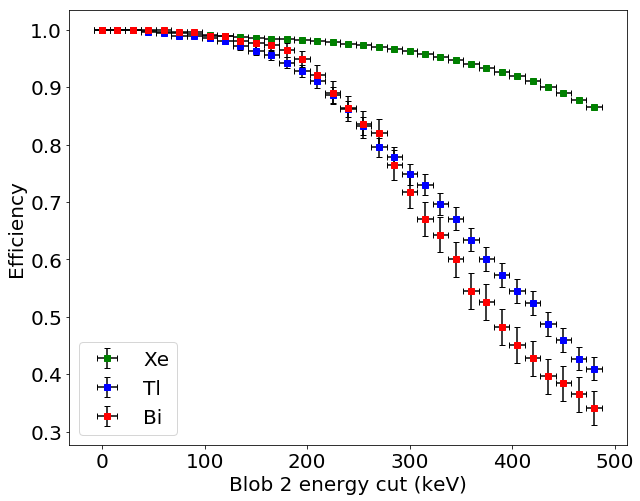

In [45]:
df_xe_roi, _ = apply_energy_roi(df_xe, roi_e_min, roi_e_max, pe2keV)
df_tl_roi, _ = apply_energy_roi(df_tl, roi_e_min, roi_e_max, pe2keV)
df_bi_roi, _ = apply_energy_roi(df_bi, roi_e_min, roi_e_max, pe2keV)

thresholds, xe_evts, tl_evts, bi_evts = topology_scan(df_xe_roi, df_tl_roi, df_bi_roi, start, end, step, pe2keV)
xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi = compute_efficiencies_and_errors(xe_evts, tl_evts, bi_evts)
plot_blob_cut_efficiency(thresholds, xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

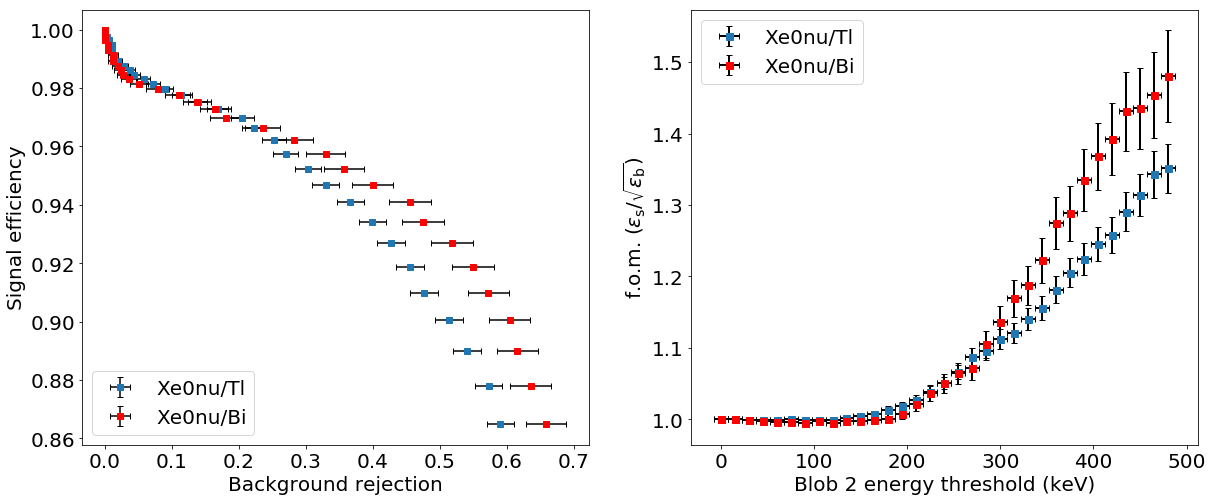

In [46]:
fom_tl, fom_bi, fom_tl_err, fom_bi_err = compute_figure_of_merit(xe_evts_norm, tl_evts_norm, bi_evts_norm, errors_xe, errors_tl, errors_bi)

bkg_rej_tl = 1 - tl_evts_norm
bkg_rej_bi = 1 - bi_evts_norm
plot_roc_curve(xe_evts_norm, bkg_rej_tl, bkg_rej_bi, errors_xe, errors_tl, errors_bi, start, end, step)

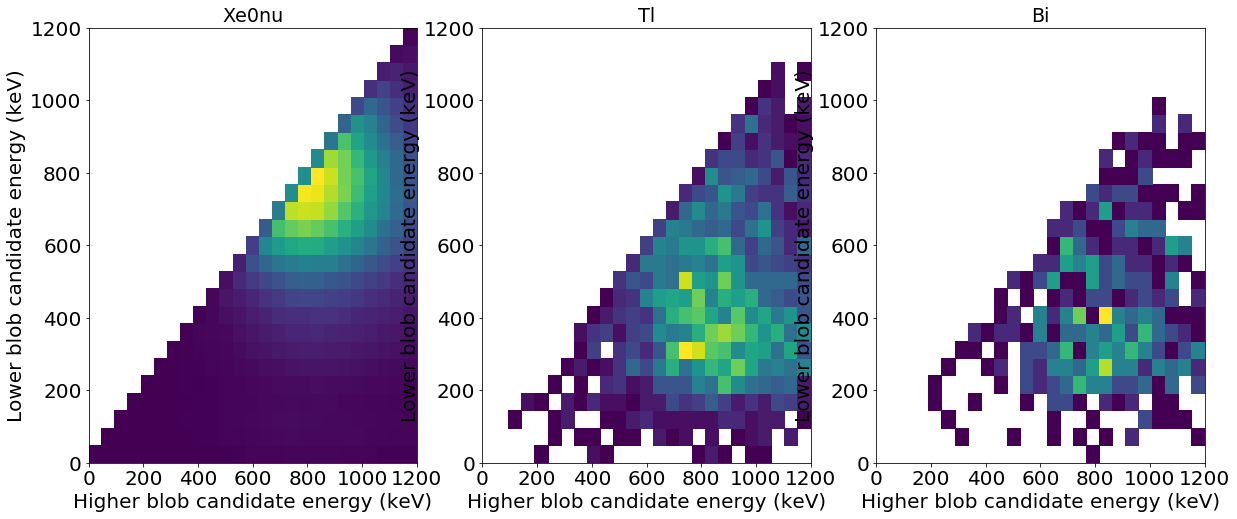

In [47]:
eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi = get_blob_energies(df_xe, df_tl, df_bi)
plot_blobs_energy(eblob1_peak_xe, eblob2_peak_xe, eblob1_peak_tl, eblob2_peak_tl, eblob1_peak_bi, eblob2_peak_bi)